# Direct measurement of afterpulsing

Afterpulsing properties can be measured direct using waveform data triggered by
the dark current discharges, and finding where how delayed a secondary plot
occurs after the primary discharge. We will start to by importing the required
libraries and loading in an example data file. 


In [1]:
import sipmanalyze.formats as forms
import sipmanalyze.plotting as plt
import awkward as ak
import numpy as np
import hist
import zfit

container = forms.waveform.waveform_container.from_root(
  'data/dark_current_waveform.root')


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Here we will compare with the neighboring time slices to find the secondary
peak. Here we define the "secondary peak" as time slices where the waveform is
at a local minimum is smaller than "-2" ADC compared with 0 (since the inputs to
the picoscope is AC coupled, the baseline should be 0). 

As the waveform used for this analysis has many temporal samples, we split the
computation into batches of 10K waveforms per batch.

In [2]:
tint = container.settings.timeintervals
tmin = tint
tmax = len(container.waveforms[0])
tdiff = ak.Array([])

n_batch = 10000
for i in range(0, len(container.waveforms), n_batch):
  print(f'\rRunning events: {i+1}-{i + n_batch}...', end='')
  waveforms = container.waveforms[i:i + n_batch]
  peak = waveforms[:, 1:-1]
  pre_peak = waveforms[:, :-2]
  post_peak = waveforms[:, 2:]

  t = ak.local_index(waveforms, axis=-1) * tint
  tmin, tmax = tint, ak.max(t) + tint
  is_peak = (peak < (pre_peak - 1)) & (peak < (post_peak - 1))  & (peak < -3)
  t = ak.pad_none(t[is_peak], 2, axis=-1)
  diff = (t[:, 1] - t[:, 0]) * tint
  diff = diff[~ak.is_none(diff)]
  tdiff = ak.concatenate([tdiff, diff])

print('Complete!')

Running events: 90001-100000...Complete!


Next we set up the parameters for the fit. The secondary peak arrival time
should follow a double exponential distribution:

$$
P(t\; f, \tau_{a.p.}, \tau_{d.c.}, )
=
\frac{f}{\tau_{a.p.}} e^{-t/\tau_{a.p.}} + \frac{1-f}{\tau_{d.c.}}e^{-t/\tau_{d.c.}},
$$

Where $\tau_{a.p.}$ and $\tau_{d.c.}$ is the after pulse and dark current time
scale respectively, and $f$ is the afterpulsing probability. Here we setup these
variable to be defined using the `zfit.pdf` framework. Arrival time is split
into discrete time bins, we also need to take time to modify the NLL function to
take in binned data formats. The bin also only starts at 48 seconds as before
that the effects is dominated by the scope voltage resolution's ability to
distinguish between peaks in the falling edge of the initial pulse.


In [3]:
obs_unbinned = zfit.Space('t', limits=(48, 2000))
data_unbinned = zfit.Data.from_numpy(obs_unbinned, ak.to_numpy(tdiff))
tau_ap = zfit.Parameter("tau_ap", 20.0, 2, 100)
tau_dc = zfit.Parameter("tau_dc", 1000.0, 2, 100_000)
lam_ap = zfit.ComposedParameter('lam_ap', lambda x: -1. / x, params=(tau_ap, ))
lam_dc = zfit.ComposedParameter('lam_dc', lambda x: -1. / x, params=(tau_dc, ))
pdf_ap = zfit.pdf.Exponential(obs=obs_unbinned, lam=lam_ap)
pdf_dc = zfit.pdf.Exponential(obs=obs_unbinned, lam=lam_dc)
frac = zfit.Parameter('frac', 0.10, 0.0, 1.0)
pdf_unbinned = zfit.pdf.SumPDF(pdfs=[pdf_ap, pdf_dc], fracs=frac)

binning = zfit.binned.RegularBinning(244, 48, 2000, name='t')
obs_binned = zfit.Space('t', binning=binning)
data_binned = data_unbinned.to_binned(obs_binned)
pdf_binned = zfit.pdf.BinnedFromUnbinnedPDF(pdf_unbinned, obs_binned)


Next we can run the fitting routine.

In [4]:
nll = zfit.loss.BinnedNLL(pdf_binned, data_binned)
minimizer = zfit.minimize.Minuit()
results = minimizer.minimize(nll)
results.hesse()
print(results)

/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f96c427c700>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f96c423cf10>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 7.2e-06 │ 962.6979    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
frac             0.0644074  +/-  0.0045       False
tau_ap             24.2452  +/-     2.3       False
tau_dc             17245.3  +/- 7.6e+03       False


And plot the results onto a canvas!

/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1316: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(
/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1337: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be removed in the future. INSTRUCTIONS: to stay compatible, change wherever you access the error to 'errors' or specify the name explici

(0.0, 2.0)

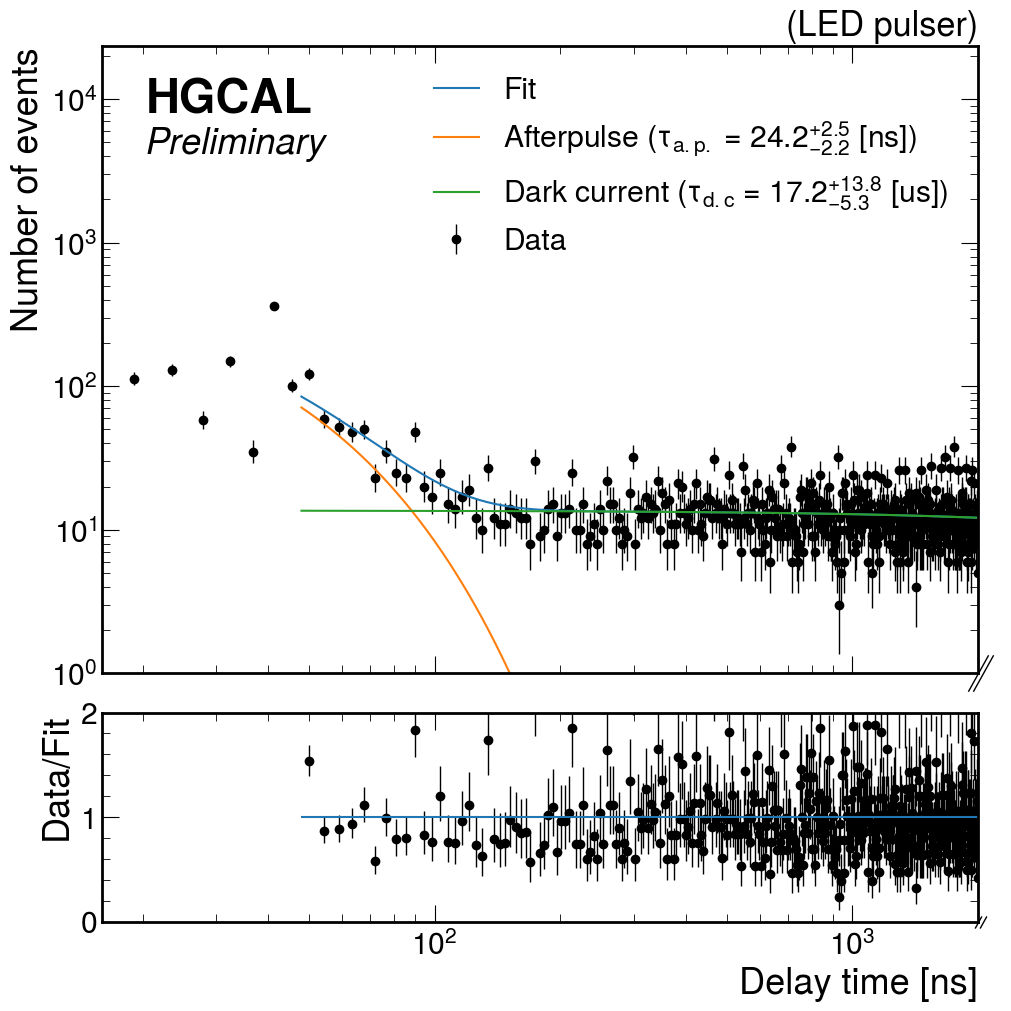

In [5]:
fig, (ax1, ax2) = plt.make_ratio_figure()

h = hist.Hist(hist.axis.Regular(450, 8, 2000, name='t'))
h.fill(t=tdiff)

errors = results.error([tau_ap, tau_dc, frac])

tap = float(tau_ap.value())
tap_lo = errors[tau_ap]['lower']
tap_up = errors[tau_ap]['upper']
tap_str = plt.number_str(tap, (tap_up, tap_lo))

tdc = float(tau_dc.value()) / 1000
tdc_lo = errors[tau_dc]['lower'] / 1000
tdc_up = errors[tau_dc]['upper'] / 1000
tdc_str = plt.number_str(tdc, (tdc_lo, tdc_up))

data_style = plt.datastyle(zorder=-1, markersize=6)

plt.plot_data1d(ax=ax1, data=h, label='Data', histtype='errorbar', **data_style)
scale = dict(data=h, prange=(48, 2000))
plt.plot_pdf1d(ax=ax1, pdf=pdf_unbinned, **scale, label='Fit')
plt.plot_pdf1d(ax=ax1,
               pdf=pdf_ap,
               scale=frac,
               **scale,
               label=f'Afterpulse ($\\tau_{{a.p.}}$ = {tap_str} [ns])')
plt.plot_pdf1d(ax=ax1,
               pdf=pdf_dc,
               scale=(1 - frac),
               **scale,
               label=f'Dark current ($\\tau_{{d.c}}$ = {tdc_str} [us])')
plt.plot_fitratio(ax=ax2,
                  num=h,
                  den=pdf_unbinned,
                  prange=(48, 2000),
                  histtype='errorbar',
                  **data_style)
ax2.hlines([1.0], 48, 2000)

ax1.set_xlim(16, 2000)
ax1.legend()
ax1.set_xlabel('')
ax1.set_ylabel('Number of events')
ax2.set_xlabel('Delay time [ns]')
ax2.set_ylabel('Data/Fit')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.add_std_label(ax=ax1, label="Preliminary", rlabel='(LED pulser)')
ax1.set_ylim(bottom=np.min(h.view()[h.view() > 0]) / 3)
ax2.set_ylim(bottom=0, top=2)
